In [49]:
#import libraries required
import numpy as np
import pandas as pd
#handwriting examples
from tensorflow.keras.datasets import mnist
#plotting
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
#learning and testing
import warnings
from sklearn.linear_model import LogisticRegression

In [50]:
#load data and get the train and test data
handwriting_dataset = mnist.load_data()
print("Length of data: {}, \n length of each entry in the data: {}".format(len(handwriting_dataset), len(handwriting_dataset[0])))
print("the dataset is thus in the form of (trainX, trainy), (testX, testy)")
(trainX, trainy), (testX, testy) = handwriting_dataset

Length of data: 2, 
 length of each entry in the data: 2
the dataset is thus in the form of (trainX, trainy), (testX, testy)


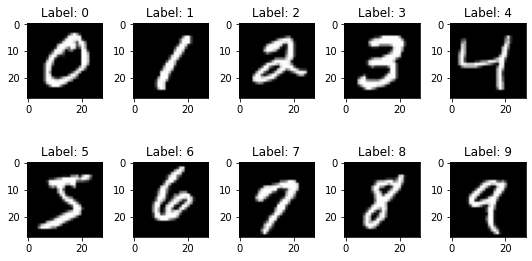

In [51]:
#see few examples
images = []
labels = []

for i in range(10): 
    #selecting one example from each class
    idx = np.where(np.squeeze(trainy==i))[0][0]
    labels.append(i)
    images.append(trainX[idx])
    
# plot images
fig, axes = plt.subplots(2, 5, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[int(i/num_col), i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [52]:
print("Train shape: X = {}, y = {} \n Test shape: X = {}, y = {}".format(trainX.shape, trainy.shape, testX.shape, testy.shape))
print("Rastorize the images: ")
#rastorize the images and transpose it
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1]*trainX.shape[2]).T
testX = testX.reshape(testX.shape[0], testX.shape[1]*testX.shape[2]).T
print("Train shape: X = {}, y = {} \n Test shape: X = {}, y = {}".format(trainX.shape, trainy.shape, testX.shape, testy.shape))
#rescale
trainX = trainX/255
testX = testX/255

Train shape: X = (60000, 28, 28), y = (60000,) 
 Test shape: X = (10000, 28, 28), y = (10000,)
Rastorize the images: 
Train shape: X = (784, 60000), y = (60000,) 
 Test shape: X = (784, 10000), y = (10000,)


In [53]:
#Doing all operations on the training data only
#we want mu to be Dx1 dimensional (it is the expected value of the datapoints)
mu = np.mean(trainX, axis=1, keepdims=True)
#covariance matrix of the data
S = ((trainX - mu) @ (trainX - mu).T)/trainX.shape[1]
print("Covariance matrix shape (DxD) = ",S.shape)

Covariance matrix shape (DxD) =  (784, 784)


In [54]:
#compute the projection space, argument k: no. components required
def learn_project_eig_space(S, k, X):
    #find all the 784 eigen values and vector
    eigen_val, eigen_vectors = np.linalg.eig(S)
    #argsort gives the position of the elements in the sorted array w.r.t the original array 
    eigen_vectors_top_k_pos = np.argsort(eigen_val*-1)[0:k]
    #documentation: such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    eigen_vectors_top_k = eigen_vectors[:, eigen_vectors_top_k_pos]
    print("Shape of transformation matrix",eigen_vectors_top_k.shape)
    Z = (eigen_vectors_top_k.T @ X)
    return Z.real, eigen_vectors_top_k.real

#this is specially made for the test examples as they should not be included in calculating the statistics
def transform_to_space(X, eigen_vectors_top_k):
  return (eigen_vectors_top_k.T @ X).real

In [55]:
#covariance matrix is real, symmetric matrix and hence all eigen values and vectors are real numbers
Z_3, top3_eig_vect = learn_project_eig_space(S, 3, trainX)
print("Shape of the projected data: ",Z_3.shape)

Shape of transformation matrix (784, 3)
Shape of the projected data:  (3, 60000)


In [56]:
def plot_reduction_2D(X, y):
    #colour selection
    ch = np.random.choice(range(X.shape[1]), 1000, replace=False)
    X_1000 = X[:, ch]
    y_1000 = y[ch]
    colours = ['red', 'royalblue', 'olive', 'goldenrod', 'black', 'yellow', 'green', 'grey', 'purple', 'cyan']
    colour_list = np.vectorize(lambda x: colours[x % len(colours)])
    
    fig = plt.figure()
    ax = plt.axes()
    for i in range(X_1000.shape[1]):
        ax.scatter(X_1000[0,i], X_1000[1,i], cmap=colour_list(y_1000[i]), label=y_1000[i])
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("MNIST on 2 components")
    leg = plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='lower left', fontsize='x-small')
    for i in range(10):
        leg.legendHandles[i].set_color(colours[i])
    plt.show()

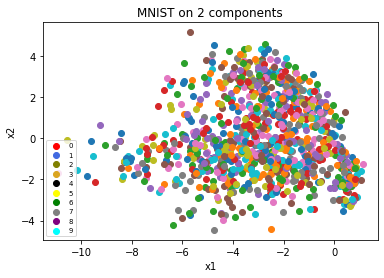

In [57]:
plot_reduction_2D(Z_3, trainy)

In [58]:
def plot_reduction_3D(X, y):
    #colour selection
    ch = np.random.choice(range(X.shape[1]), 1000, replace=False)
    X_1000 = X[:, ch]
    y_1000 = y[ch]
    colours = ['red', 'royalblue', 'olive', 'goldenrod', 'black', 'yellow', 'green', 'grey', 'purple', 'cyan']
    colour_list = np.vectorize(lambda x: colours[x % len(colours)])
    
    fig = plt.figure(figsize = (16, 9))
    ax = plt.axes(projection='3d')
    for i in range(X_1000.shape[1]):
        ax.scatter3D(X_1000[0,i], X_1000[1,i], X_1000[2,i], cmap=colour_list(y_1000[i]), label=y_1000[i])
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    plt.title("MNIST on 2 components")
    leg = plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='lower left', fontsize='x-small')
    
    for i in range(10):
        leg.legendHandles[i].set_color(colours[i])
    plt.show()

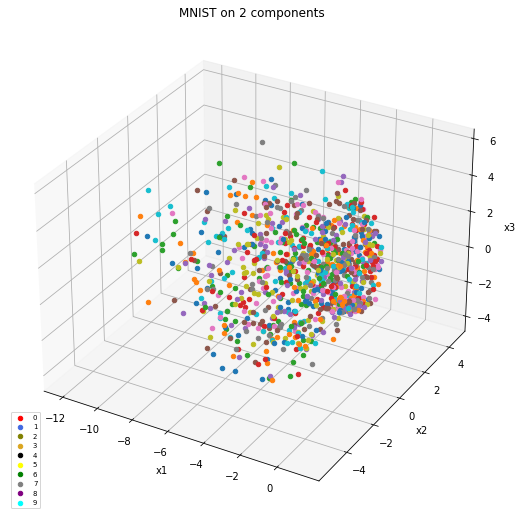

In [59]:
plot_reduction_3D(Z_3, trainy)

In [60]:
#let us build a classifier and see

def return_train_testacc(trainX, trainy, testX, testy):
  train_acc, test_acc = 0, 0
  #learn the classifier on the trainset
  warnings.filterwarnings('ignore', category=UserWarning, append=True)
  classifier = LogisticRegression(max_iter=500).fit(trainX.T, trainy)
  #test the classifier
  train_acc = classifier.score(trainX.T, trainy)
  test_acc = classifier.score(testX.T, testy)
  return train_acc, test_acc 

#this is convert into low dimensional space and will see the classification accuracy
def dim_reduced_model(trainX, trainy, testX, testy, n_comp):
  mu = np.mean(trainX, axis=1, keepdims=True)
  S = ((trainX - mu) @ (trainX - mu).T)/trainX.shape[1]
  train_acc = []
  test_acc = []
  for n in n_comp:
    trainZ_n, topn_eig_vect = learn_project_eig_space(S, n, trainX)
    testZ_n = transform_to_space(testX, topn_eig_vect)
    #see how the classifer performs on n components
    tr, tt = return_train_testacc(trainZ_n, trainy, testZ_n, testy)
    train_acc.append(tr)
    test_acc.append(tt)
  return train_acc, test_acc

In [46]:
#we take example of 4 case: 3, 75(~10%), 375 (~50%), 750(~all)
n_comp = [3, 75, 375, 750]
train_acc, test_acc = dim_reduced_model(trainX, trainy, testX, testy, n_comp)

Shape of transformation matrix (784, 3)
Shape of transformation matrix (784, 75)
Shape of transformation matrix (784, 375)
Shape of transformation matrix (784, 750)


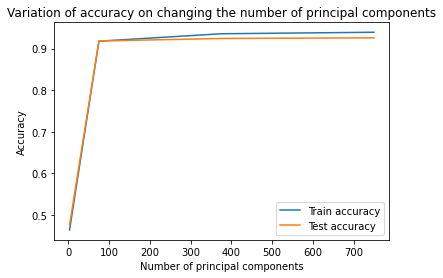

In [61]:
#plot
plt.plot(n_comp, train_acc, label='Train accuracy')
plt.plot(n_comp, test_acc, label='Test accuracy')
plt.xlabel("Number of principal components")
plt.ylabel("Accuracy")
plt.title("Variation of accuracy on changing the number of principal components")
plt.legend()
plt.show()

In [48]:
print(test_acc)

[0.4761, 0.9182, 0.9243, 0.9258]
